# Solution Assignment 7: Policy Gradients
This is the solution for the seventh assignment of the Implementing Artificial Neural Networks with TensorFlow course. Please find the according assignment sheet on studip. In this assignment, we train a reinforcement learning agent with the policy gradients to perform the _cart pole_ task.

## Imports
We are going to use OpenAi's `gym` library to generate an environment that we can use to train our reinforcement learning agent. Further, `tensorflow` is going to be used to implement the neural network, `numpy` for numerical operations outside of the computational graph and `matplotlib` to plot the training process. Finally, we activate inline plotting by calling `%matplotlib notebook`.

In [38]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gym

%matplotlib inline

## Helperfunction

This helper class is used for the creation of the fully-connected feed-forward layers of the network. It is used to map the game state onto the hidden layer and to map the hidden state onto the final output neuron.

In [8]:
def feed_forward_layer(x, target_size, activation_function = None):
    print("Forward-Layer:" + str(x.shape))
    
    fan_in = int(x.shape[-1])
    
    if activation_function == tf.nn.relu:
        var_init = tf.random_normal_initializer(stddev = 2/fan_in)
    else:
        var_init = tf.random_normal_initializer(stddev = fan_in**(-1/2))
    weights = tf.get_variable("weights", [x.shape[1], target_size], tf.float32, var_init)
    
    var_init = tf.constant_initializer(0.0)
    biases = tf.get_variable("biases", [target_size], tf.float32, var_init)
    
    activation = tf.matmul(x, weights) + biases
    
    return activation_function(activation) if callable(activation_function) else activation

    

## Hyperparameters

The network's hidden layer has 8 neurons. The initial learning rate is 0.025 and we exponentially decay it with a decay rate of 0.8. The discount factor is 0.99 and hence our agent is very far-sighted. Parameters are updated after every 10 rounds of playing and in total, we play 400 rounds of cart pole.

## Construction phase

Next, the computational graph of the network is created. Each observation is mapped onto a hidden layer with 8 hidden neurons. In a second and final layer, the hidden state is mapped onto a single output neuron with sigmoid activation function. This neuron indicates the probability of moving the cart towards the right.

![PICTURE MISSING](network-structure.png)

Afterwards, we calculate the probability of moving the cart towards the left and create a tensor containing the probability distribution over both actions.

In [9]:
tf.reset_default_graph()

observation = tf.placeholder(tf.float32, [None, 4])
global_step = tf.Variable(0, trainable = False)

with tf.variable_scope("readout_layer"):
    readout_layer = feed_forward_layer(observation, hidden_layer_size, tf.nn.tanh)
    
with tf.variable_scope("output_layer"):
    action_probability = feed_forward_layer(readout_layer, 1, tf.nn.sigmoid)
    action_probabilities = tf.concat([action_probability, 1 - action_probability], axis = 1)
    

NameError: name 'hidden_layer_size' is not defined

In the next step, we sample the agent's action from that probability distribution and select the respective node in the computational graph to calculate the gradient with respect to that action.

In [ ]:
with tf.variable_scope("action_selection"):
    log_probabilities = tf.log(action_probabilities)
    action = tf.multinomial(log_probabilities, num_samples = 1)[0][0]
    log_probability = log_probabilities[:, tf.to_int32(action)]

Then, we create an optimizer and define the exponenital decay rule for the learning rate. We use the optimizer to calculate the gradient of the chosen action - or in other words: We get the rate of change of the current action with respect to our parameters. Hence, we can increase the probability of the action by following the gradient direction and decrease it by updating our parameters in the opposite direction.

The `AdamOptimizer` returns inverted gradients for minimizing an objective function, therefore we need to invert them again to restore the original gradients.

We then create a list of placeholders, such that we can feed in and apply the modified gradients and finally, an operation to apply the gradients to the respective parameters.

In [ ]:
with tf.variable_scope("gradients"):
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gradients_and_variables = optimizer.compute_gradients(log_probability)
    gradients = [gradient_and_variable[0] * -1 for gradient_and_variable in gradients_and_variables]

# Create placeholders for gradient tensors
with tf.variable_scope("gradient_placeholder"):
    gradient_placeholders = []
    for gradient in gradients:
        gradient_placeholders.append(tf.placeholder(tf.float32, gradient.shape))

with tf.variable_scope("training"):
    trainable_variables = tf.trainable_variables()
    training_step = optimizer.apply_gradients(zip(gradient_placeholders, trainable_variables), global_step = global_step)

## Discounted rewards

Policy Gradients are a Monta Carlo method. First, we create a trajectory by following the current policy until we reach a final state. With the experience, we then can calculate the discounted rewards.

In [ ]:
def discount_rewards(rewards, discount_factor):
    discounted_rewards = np.zeros_like(rewards, dtype=np.float32)
    for i, reward in enumerate(reversed(rewards)):
        discounted_rewards[-(i+1)] = discounted_rewards[-i] * discount_factor + reward
    return discounted_rewards

## Execution phase

First, a new _cart pole_ environment is created and we create arrays that we can use to cache rewards and gradients.

We then play batch\_size games. In each of those games, we sample an action from out network, store the respective gradient and execute the action in order to retrieve a new observation. Once we reached a final state, we calculate and normalize the rewards. As a result, rewards that are below average are negative and rewards that are above average are positive. Further, we weight the gradients with the respective discounted and normalized reward. We are hence going to encourage early actions and discourage later ones that let to failure.

After we have played batch\_size rounds, we apply the gradients.

In [32]:
def train(learning_rate):
    env = gym.make("CartPole-v0")

    hidden_layer_size = 8

    initial_learning_rate = learning_rate
    decay_steps = 100
    decay_rate = 1

    discount_factor = 0.99

    batch_size = 10
    training_episodes = 400
    
    tf.reset_default_graph()

    observation = tf.placeholder(tf.float32, [None, 4])
    global_step = tf.Variable(0, trainable = False)

    with tf.variable_scope("readout_layer"):
        readout_layer = feed_forward_layer(observation, hidden_layer_size, tf.nn.tanh)

    with tf.variable_scope("output_layer"):
        action_probability = feed_forward_layer(readout_layer, 1, tf.nn.sigmoid)
        action_probabilities = tf.concat([action_probability, 1 - action_probability], axis = 1)

    with tf.variable_scope("action_selection"):
        log_probabilities = tf.log(action_probabilities)
        action = tf.multinomial(log_probabilities, num_samples = 1)[0][0]
        log_probability = log_probabilities[:, tf.to_int32(action)]

    with tf.variable_scope("gradients"):
        learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        gradients_and_variables = optimizer.compute_gradients(log_probability)
        gradients = [gradient_and_variable[0] * -1 for gradient_and_variable in gradients_and_variables]

    # Create placeholders for gradient tensors
    with tf.variable_scope("gradient_placeholder"):
        gradient_placeholders = []
        for gradient in gradients:
            gradient_placeholders.append(tf.placeholder(tf.float32, gradient.shape))

    with tf.variable_scope("training"):
        trainable_variables = tf.trainable_variables()
        training_step = optimizer.apply_gradients(zip(gradient_placeholders, trainable_variables), global_step = global_step)        

    def discount_rewards(rewards, discount_factor):
        discounted_rewards = np.zeros_like(rewards, dtype=np.float32)
        for i, reward in enumerate(reversed(rewards)):
            discounted_rewards[-(i+1)] = discounted_rewards[-i] * discount_factor + reward
        return discounted_rewards        
        
    rewards_cache = []
    mean_gradients_cache = []

    with tf.Session() as session:
        saver = tf.train.Saver()
        session.run(tf.global_variables_initializer())
        for episode in range(training_episodes):
            mean_gradients = []

            for batch in range(batch_size):
                done = False
                rewards = []
                sampled_gradients = []

                game_state = env.reset()

                while not done:
                    #if (episode % 10 == 0 and batch == 0) or episode == training_episodes - 1:
                        #env.render()

                    game_state = np.reshape(game_state, [1, -1])
                    sampled_action, sampled_gradient = session.run(
                        [action, gradients],
                        feed_dict = {
                            observation: game_state
                        })

                    sampled_gradients.append(sampled_gradient)

                    game_state, reward, done, _ = env.step(sampled_action)
                    rewards.append(reward)

                rewards_cache.append(np.sum(rewards))

                rewards = discount_rewards(rewards, discount_factor)
                rewards = ((rewards - np.mean(rewards)) / np.std(rewards))

                # Scale gradients by normalized discounted reward
                scaled_gradients = np.reshape(rewards, [-1, 1]) * np.array(sampled_gradients)

                # Calculate mean gradient
                mean_gradients.append(np.sum(scaled_gradients, axis = 0))

                mean_gradients_cache.append(mean_gradients)        


            for mean_gradient in mean_gradients:
                feed_dict = {placeholder: mean_gradient[i] for i, placeholder in enumerate(gradient_placeholders)}
                session.run(training_step, feed_dict = feed_dict)        
        saver.save(session, "./07.ckpt")
    env.close()
    return rewards_cache

# Experiment methods 
## same as A3C but fitted to code

In [35]:
def test(test_episodes): 
    
    hidden_layer_size = 8
    
    tf.reset_default_graph()
    
    observation = tf.placeholder(tf.float32, [None, 4])
    global_step = tf.Variable(0, trainable = False)

    with tf.variable_scope("readout_layer"):
        readout_layer = feed_forward_layer(observation, hidden_layer_size, tf.nn.tanh)

    with tf.variable_scope("output_layer"):
        action_probability = feed_forward_layer(readout_layer, 1, tf.nn.sigmoid)
        action_probabilities = tf.concat([action_probability, 1 - action_probability], axis = 1)
    
    with tf.variable_scope("action_selection"):
        log_probabilities = tf.log(action_probabilities)
        action = tf.multinomial(log_probabilities, num_samples = 1)[0][0]
    
    env = gym.make('CartPole-v0')
    
    reward_list = []
    
    saver = tf.train.Saver()

    with tf.Session() as sess:
        
        saver.restore(sess, "./07.ckpt")
        
        for _ in range(test_episodes):

            done = False
            rewards = []


            game_state = env.reset()

            while not done:
                #if (episode % 10 == 0 and batch == 0) or episode == training_episodes - 1:
                    #env.render()

                game_state = np.reshape(game_state, [1, -1])
                sampled_action = sess.run(
                    action,
                    feed_dict = {
                        observation: game_state
                    })

                game_state, reward, done, _ = env.step(sampled_action)
                rewards.append(reward)

            reward_list.append(np.sum(rewards))

    return np.mean(reward_list)

In [45]:
experiments = 15
test_episodes = 100
rewards_cache =[]
means = []
stds = []

learning_rates = np.logspace(-10, -1, 10)

for learning_rate in learning_rates:
    experiment_list = []
    for _ in range(experiments):
        rewards_cache = train(learning_rate)
        experiment_list.append(test(test_episodes))

    means.append(np.mean(experiment_list))
    stds.append(np.std(experiment_list)/ np.sqrt(experiments))



WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from ./07.ckpt
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from ./07.ckpt
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from ./07.ckp

Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from ./07.ckpt
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from ./07.ckpt
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from ./07.ckpt
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from ./07.ckpt
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from ./07.ckpt
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from ./07.ckp

Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from ./07.ckpt
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from ./07.ckpt
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from ./07.ckpt
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from ./07.ckpt
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from ./07.ckpt
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from ./07.ckp

Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from ./07.ckpt
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from ./07.ckpt
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from ./07.ckpt
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8

InvalidArgumentError: slice index 2 of dimension 1 out of bounds.
	 [[Node: action_selection/strided_slice_2 = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=1, ellipsis_mask=0, end_mask=1, new_axis_mask=0, shrink_axis_mask=2, _device="/job:localhost/replica:0/task:0/cpu:0"](action_selection/Log, action_selection/strided_slice_2/stack, action_selection/strided_slice_2/stack_1, action_selection/strided_slice_2/stack_2)]]

Caused by op 'action_selection/strided_slice_2', defined at:
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-8b224a71bf77>", line 12, in <module>
    rewards_cache = train(learning_rate)
  File "<ipython-input-32-de7741a7ba06>", line 30, in train
    log_probability = log_probabilities[:, tf.to_int32(action)]
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\array_ops.py", line 499, in _SliceHelper
    name=name)
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\array_ops.py", line 663, in strided_slice
    shrink_axis_mask=shrink_axis_mask)
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 3515, in strided_slice
    shrink_axis_mask=shrink_axis_mask, name=name)
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): slice index 2 of dimension 1 out of bounds.
	 [[Node: action_selection/strided_slice_2 = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=1, ellipsis_mask=0, end_mask=1, new_axis_mask=0, shrink_axis_mask=2, _device="/job:localhost/replica:0/task:0/cpu:0"](action_selection/Log, action_selection/strided_slice_2/stack, action_selection/strided_slice_2/stack_1, action_selection/strided_slice_2/stack_2)]]


[24.098000000000003, 21.58933333333333, 21.798666666666666, 23.888666666666662, 23.863999999999997, 24.842, 41.211999999999996, 198.268, 184.01733333333337]
[1.6372606389942927, 0.8780030203272102, 1.561431498954061, 1.349751208899598, 1.3863518232316707, 1.9045692893086819, 4.745818014022685, 0.23029102361046275, 6.58794477927789]


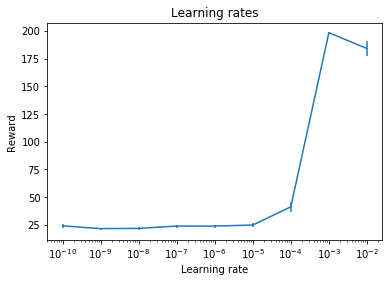

In [49]:
print(means)
print(stds)
fig, ax = plt.subplots()
ax.set_title("Learning rates")
ax.set_xlabel("Learning rate")
ax.set_ylabel("Reward")
ax.errorbar(learning_rates[:9:], means, yerr = stds)
ax.set_xscale("log", nonposx='clip')

## Plotting

After training our network, we can plot the result of the training process.

<IPython.core.display.Javascript object>


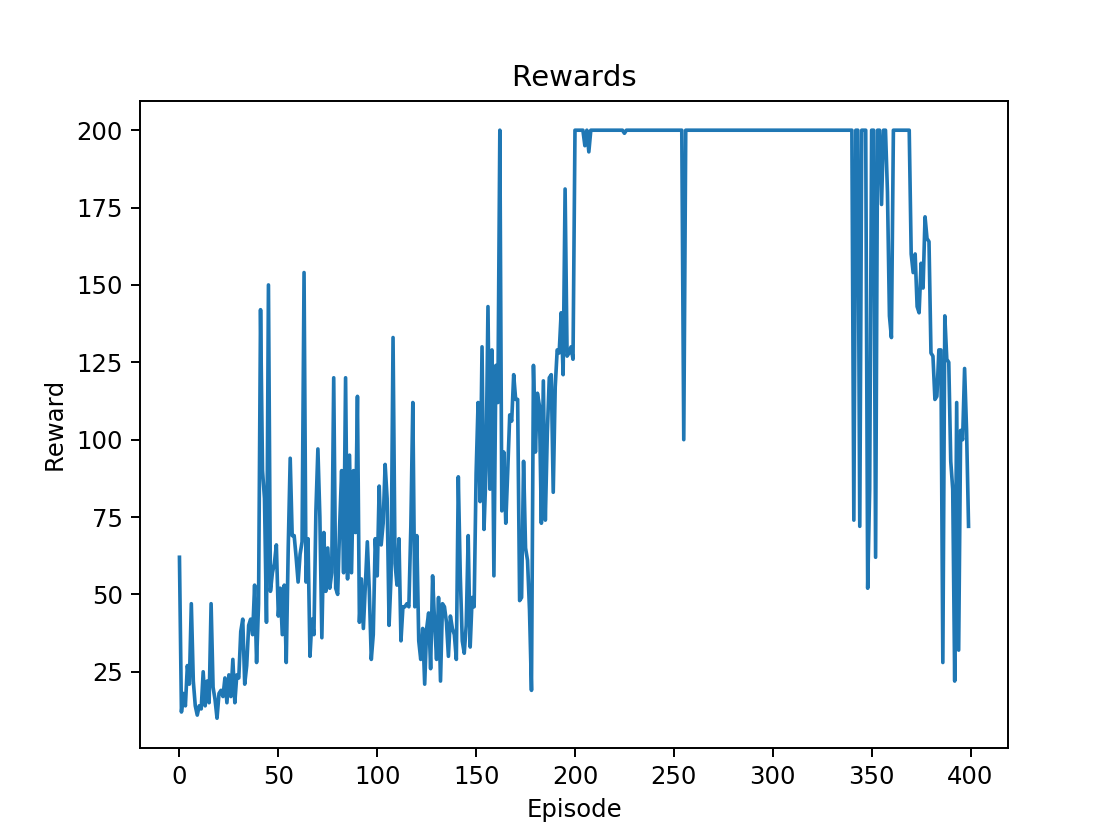

In [12]:
fig, ax = plt.subplots(1)

ax.set_title("Rewards")
ax.set_xlabel("Episode")
ax.set_ylabel("Reward")

ax.plot(rewards_cache)

This solution is brought to you by Lukas Braun. If you have any questions or comments, please do not hesitate to contact lbraun@uos.de